# About this notebook:
### Minneapolis condemned tree data analysis

This notebook includes:
- Basic facts about condemned tree assessment in North Minneapolis and Other neighborhoods.
- Statistical hypothesis tests to interrogate if disparities between the two neighborhood is statisically significant.

Source of this data: Minneapolis Park and Recreation Board, via data request by Sahan Journal. Sahan Journal has published this data in this repository.

Read the story here:

### Have questions, comments, or feedback?
Contact Sahan Journal's data reporter Cynthia Tu ctu@sahanjournal.com, or climate reporter Andrew Hazzard ahazzard@sahanjournal.com.

In [1]:
import pandas as pd

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

require('tidyverse')
require('DescTools')
require('ggplot2')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse
Loading required package: DescTools


In [4]:
df = pd.read_excel("CondemnedPrivateAshMpls_20130101-20230908_20231011.xlsx",\
                   sheet_name="Data")
df.head(2)

,Count,Address,Parcel ID,Area,Tree Type,Pest Reason,Inspect Date,Assessed,Cost per Trunk Inch,Trunk Size,Trunk Cost
0,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,17.0,NaN
1,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,11.0,NaN


In [5]:
df.shape

(18316, 11)

In [6]:
# convert inspection date to datetime
df['Year'] = pd.DatetimeIndex(df['Inspect Date']).year

### Some basic facts about this dataset

In [7]:
# get the number of tree removal by property tax assessments,
#  and via private contractors
df['Assessed'].value_counts()

Not Assessed    10614
Assessed         7702
Name: Assessed, dtype: int64

In [8]:
# Look at the 10 most expensive trees
df.sort_values(by='Trunk Cost', ascending=False).head(10)

,Count,Address,Parcel ID,Area,Tree Type,Pest Reason,Inspect Date,Assessed,Cost per Trunk Inch,Trunk Size,Trunk Cost,Year
4174,1,5617 IRVING AVE S,2102824240136,Other Neighborhoods,Ash,EAB,2020-01-28,Assessed,303.030303,33.0,10000.0,2020
17991,1,5843 SUNRISE DR,2102824310001,Other Neighborhoods,Ash,EAB,2023-03-09,Assessed,314.285714,28.0,8800.0,2023
13232,1,4915 EMERSON AVE S,1602824130160,Other Neighborhoods,Ash,EAB,2021-12-22,Assessed,227.272727,33.0,7500.0,2021
8731,1,4421 BEARD AVE S,802824340111,Other Neighborhoods,Ash,EAB,2021-02-12,Assessed,208.333333,36.0,7500.0,2021
13973,1,221 NEWTON AVE S,2802924220118,Other Neighborhoods,Ash,EAB,2022-01-20,Assessed,182.926829,41.0,7500.0,2022
8720,1,4425 BEARD AVE S,802824340110,Other Neighborhoods,Ash,EAB,2021-02-12,Assessed,208.333333,36.0,7500.0,2021
13598,1,1705 25TH AVE N,1602924210065,North Neighborhoods,Ash,EAB,2022-01-10,Assessed,226.666667,30.0,6800.0,2022
15227,1,2939 PIERCE ST N E,102924340180,Other Neighborhoods,Ash,EAB,2022-03-31,Assessed,182.000000,37.0,6734.0,2022
8732,1,5610 NICOLLET AVE S,2202824240052,Other Neighborhoods,Ash,EAB,2021-02-12,Assessed,174.857143,35.0,6120.0,2021
15527,1,3533 5TH ST N E,202924210091,Other Neighborhoods,Ash,EAB,2022-07-11,Assessed,175.000000,34.0,5950.0,2022


In [9]:
# Total cost of tree assessments from 2013 to 2023, in all of Minneapolis
df['Trunk Cost'].sum()

7334046.92

In [10]:
# Total cost of tree assessments from 2013 to 2023, in North Minneapolis
df[df['Area']=='North Neighborhoods']['Trunk Cost'].sum()

2780359.95

In [11]:
# summary data of tree removal by trunk diameter of all assessed trees
assessed = df[df['Cost per Trunk Inch'] !=0]
assessed.describe()

,Count,Parcel ID,Cost per Trunk Inch,Trunk Size,Trunk Cost,Year
count,7698.0,7.698000e+03,7696.000000,7696.000000,7696.000000,7698.000000
mean,1.0,1.281616e+12,51.593012,16.926715,952.968675,2020.792544
std,0.0,9.348644e+11,36.961347,7.454525,918.364761,1.729299
min,1.0,1.028241e+11,3.409091,1.000000,18.250000,2013.000000
25%,1.0,4.029243e+11,22.000000,12.000000,333.330000,2020.000000
50%,1.0,1.102824e+12,45.000000,16.000000,630.000000,2021.000000
75%,1.0,1.902823e+12,65.217391,22.000000,1200.000000,2022.000000
max,1.0,3.602924e+12,633.330000,52.000000,10000.000000,2023.000000


## Exploratory data viz

In [12]:
# Create a pivot table for all tree removals via assessments

table = pd.pivot_table(assessed, values='Count', index=['Year'],
                       columns=['Area'], aggfunc="count")
table.reset_index()

Area,Year,North Neighborhoods,Other Neighborhoods
0,2013,NaN,38.0
1,2014,NaN,30.0
2,2015,NaN,75.0
3,2016,71.0,49.0
4,2017,60.0,56.0
5,2018,97.0,194.0
6,2019,173.0,369.0
7,2020,241.0,908.0
8,2021,1757.0,1252.0
9,2022,575.0,544.0


Create a bar chart with number of assessment by year, by neighborhood areas

<AxesSubplot: title={'center': 'Number of Assessment by year'}, xlabel='Year'>

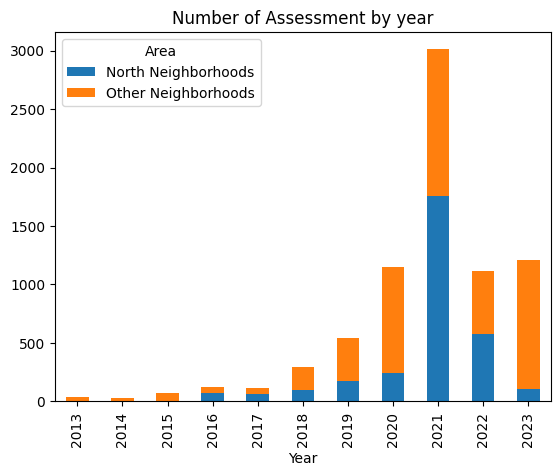

In [13]:
table.plot(kind='bar', stacked=True, title="Number of Assessment by year")


In [14]:
# Create a pivot table for all tree removals

table_all = pd.pivot_table(df, values='Count', index=['Year'],
                       columns=['Area'], aggfunc="count")
table_all.reset_index().head(2)

Area,Year,North Neighborhoods,Other Neighborhoods
0,2013,NaN,255.0
1,2014,1.0,52.0


<AxesSubplot: title={'center': 'Number of inspections by year'}, xlabel='Year'>

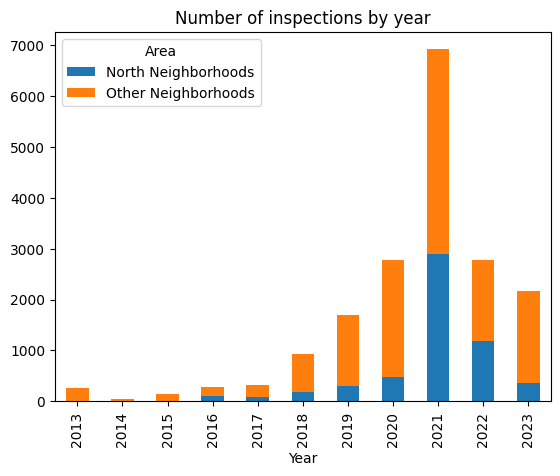

In [15]:
table_all.plot(kind='bar', stacked=True, title="Number of inspections by year")

In [16]:
# Create a table for percentage of assessments by neighborhoods
table['sum'] = table['North Neighborhoods'] + table['Other Neighborhoods']
table['North Pct'] = table['North Neighborhoods']/table['sum']
table['Other Pct'] = table['Other Neighborhoods']/table['sum']
table

Area,North Neighborhoods,Other Neighborhoods,sum,North Pct,Other Pct
Year,,,,,
2013,NaN,38.0,NaN,NaN,NaN
2014,NaN,30.0,NaN,NaN,NaN
2015,NaN,75.0,NaN,NaN,NaN
2016,71.0,49.0,120.0,0.591667,0.408333
2017,60.0,56.0,116.0,0.517241,0.482759
2018,97.0,194.0,291.0,0.333333,0.666667
2019,173.0,369.0,542.0,0.319188,0.680812
2020,241.0,908.0,1149.0,0.209748,0.790252
2021,1757.0,1252.0,3009.0,0.583915,0.416085


What's the distribution for Trunk Cost?

<AxesSubplot: title={'center': 'Distribution of Trunk Cost for all inspections'}, ylabel='Frequency'>

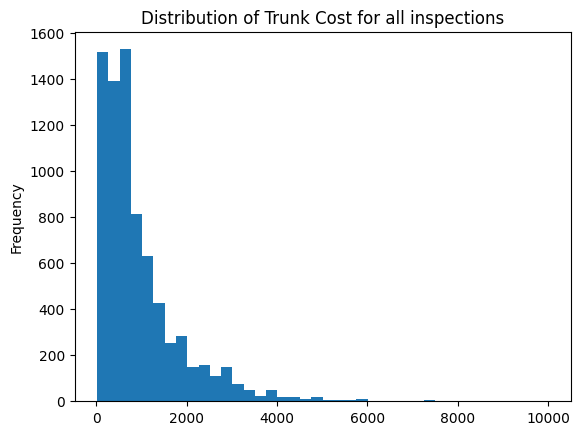

In [17]:
assessed['Trunk Cost'].plot.hist(bins=40, title = 'Distribution of Trunk Cost for all inspections')

<AxesSubplot: title={'center': 'Distribution of Cost per Trunk Inch for all inspections'}, ylabel='Frequency'>

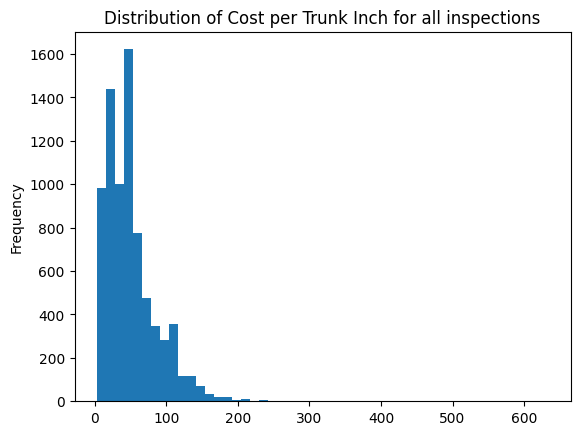

In [18]:
# What's the distribution for cost per trunk inch?

assessed['Cost per Trunk Inch'].plot.hist(bins=50, title = 'Distribution of Cost per Trunk Inch for all inspections')

# Hypothesis Testing

## Hypothesis #1: 
**North neighborhoods are more prone to being assessed compared to other neighborhoods.**

Running a Chi Square test on whether there's statistically significant disparity between north neighborhood and other neighborhoods.

In [19]:
# import packages

from pandas import crosstab
pd.options.display.max_rows = None

In [20]:
# Encode neighborhood column and accessed column to prepare for statistical testing.

df['assessed_flag'] = df['Assessed'].map({'Assessed': 1, 'Not Assessed': 0})
df['north_flag'] = df['Area'].map({'North Neighborhoods': 1, 'Other Neighborhoods': 0})
df.head()

,Count,Address,Parcel ID,Area,Tree Type,Pest Reason,Inspect Date,Assessed,Cost per Trunk Inch,Trunk Size,Trunk Cost,Year,assessed_flag,north_flag
0,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,17.0,NaN,2013,0,0
1,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,11.0,NaN,2013,0,0
2,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,7.0,NaN,2013,0,0
3,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,6.0,NaN,2013,0,0
4,1,19 BARTON AVE SE,3002923420124,Other Neighborhoods,Green Ash,EAB,2013-03-08,Not Assessed,0.0,4.0,NaN,2013,0,0


In [21]:
# basic stats on tree assessment spending, 2013-current

print("Total spending on tree assessment in all of Minneapolis:", df['Trunk Cost'].sum())
print("Total spending on tree assessment in North neighborhoods:", df[df['Area']=='North Neighborhoods']\
      ['Trunk Cost'].sum())

Total spending on tree assessment in all of Minneapolis: 7334046.92
Total spending on tree assessment in North neighborhoods: 2780359.95


/Users/tuxinyi/.pyenv/versions/3.11.0rc2/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Parcel ID". Fall back to string conversion. The error is: integer 3002923420124 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '


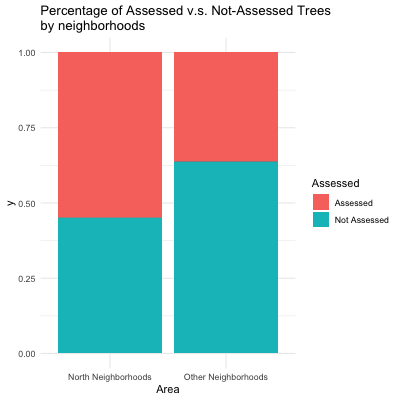

In [22]:
%%R -i df -w 400 -h 400

ggplot(df, aes(fill=Assessed, x=Area, y=1)) + 
    geom_bar(position="fill", stat="identity")+
    labs(title="Percentage of Assessed v.s. Not-Assessed Trees \nby neighborhoods") +
    theme_minimal()

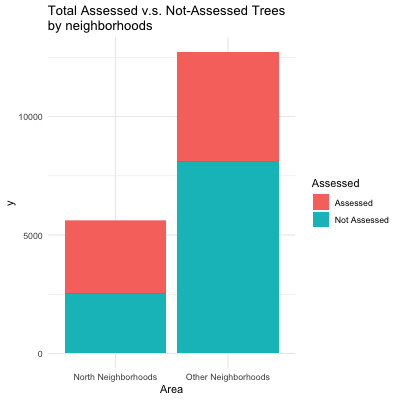

In [23]:
%%R -i df -w 400 -h 400

ggplot(df, aes(fill=Assessed, x=Area, y=1)) + 
    geom_bar(position="stack", stat="identity") +
    labs(title="Total Assessed v.s. Not-Assessed Trees \nby neighborhoods") +
    theme_minimal()

In [24]:
%%R -i df

# Chi Square test chance of of having trees assessed between North and other neighborhoods

to_test <- table(df$assessed_flag, df$Area)
print(to_test)
chisq.test(to_test, correct=FALSE)

   
    North Neighborhoods Other Neighborhoods
  0                2524                8090
  1                3084                4618

	Pearson's Chi-squared test

data:  to_test
X-squared = 555.59, df = 1, p-value < 2.2e-16



### Conclusion:
- P-value < 0.05, meaning that the observed difference between North neighborhoods and other neighborhoods' chance of having their trees assessed **is statistically significant**. 

#### Note on P-value:
P-value is a statisical measure used to determine of the likelihood that an observed outcome is result of chance. A smaller P-value means there's a smaller likelihood that the difference is due to simple random chance. When a p-value is smaller than 0.05, we can conclude that the outcome is statistically significant.

## Hypothesis #2
**There's a disparity between cost of trunk for North neighborhood comparing to other neighborhoods.**

In [25]:
# Comparing average and median cost between North neighborhoods and other neighborhoods
# Note: 50% stands for median

print('North Neighborhood Summary all years')
assessed[assessed['Area']== 'North Neighborhoods'].describe().loc[['mean', '50%']]

North Neighborhood Summary all years


,Count,Parcel ID,Cost per Trunk Inch,Trunk Size,Trunk Cost,Year
mean,1.0,1.022632e+12,48.639867,16.968213,901.835858,2020.779436
50%,1.0,9.029243e+11,42.000000,16.000000,666.670000,2021.000000


In [26]:
print('Other Neighborhood Summary all years')
assessed[assessed['Area']== 'Other Neighborhoods'].describe().loc[['mean', '50%']]

Other Neighborhood Summary all years


,Count,Parcel ID,Cost per Trunk Inch,Trunk Size,Trunk Cost,Year
mean,1.0,1.454627e+12,53.566683,16.898981,987.1422,2020.8013
50%,1.0,1.302824e+12,46.875000,15.000000,630.0000,2021.0000


/Users/tuxinyi/.pyenv/versions/3.11.0rc2/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Parcel ID". Fall back to string conversion. The error is: integer 3002923440019 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '
R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite values (`stat_ydensity()`). 

R[write to console]: 2: Removed 2 rows containing non-finite values (`stat_summary()`). 



In addition: Warning message:
The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


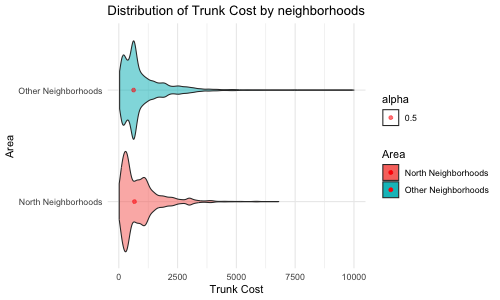

In [27]:
%%R -w 500 -h 300 -i assessed

ggplot(assessed) +
    aes(x=`Trunk Cost`, y=Area, fill=Area, alpha =0.5) + 
    geom_violin() +
    stat_summary(fun.y=median, geom="point", size=1.5, color="red")+
    labs(title="Distribution of Trunk Cost by neighborhoods") +
    theme_minimal()

Shown above's a distribution chart graphing trunk cost by neighborhoods.\
\
Though the **average** for assessment cost is **higher for other neighrborhoods**, the **median (red dot) for North neighborhood is higher**.\
This is due to a few **outliers:** standalone cases with extremely costly assesment in other neighborhoods, which **skewed the average to be higher.**

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite values (`stat_ydensity()`). 

R[write to console]: 2: Removed 2 rows containing non-finite values (`stat_summary()`). 



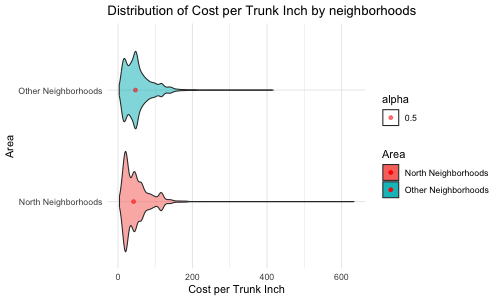

In [28]:
%%R -w 500 -h 300

ggplot(assessed) +
    aes(x=`Cost per Trunk Inch`, y=Area, fill=Area, alpha =0.5) + 
    geom_violin() +
    stat_summary(fun.y=median, geom="point", size=1.5, color="red")+
    labs(title="Distribution of Cost per Trunk Inch by neighborhoods") +
    theme_minimal()

In addition:

Though by looking at average and median, **trunk cost per inch is relatively lower in North neighborhoods**;  **variance for trunk cost per inch in North neighborhood is bigger**.

#### Next step:
Let's run a T-test to see if the difference between neighborhoods for trunk cost is statistically significant.

In [29]:
%%R -i assessed

north = df %>% filter(Area=='North Neighborhoods')
other = df %>% filter(Area=='Other Neighborhoods')

t.test(north$`Trunk Cost`, other$`Trunk Cost`)


	Welch Two Sample t-test

data:  north$`Trunk Cost` and other$`Trunk Cost`
t = -4.054, df = 7100.8, p-value = 5.088e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -125.40370  -43.65623
sample estimates:
mean of x mean of y 
 901.5434  986.0734 



### Conclusion:
From the P-value, we can conclude that the difference between trunk cost for different neighborhoods is **statistically significant**.